In [71]:
import os
import pandas as pd
import plotly.express as px
from datetime import datetime, timedelta

In [77]:
stn = 'Bechanahalli2'

In [48]:
sm = pd.read_csv(f'./{stn}/records/sm')

batt = pd.read_csv(f'./{stn}/data/battery')
itemp = pd.read_csv(f'./{stn}/data/itemp')

sm.columns = sm.columns.str.strip()
batt.columns = batt.columns.str.strip()
itemp.columns = itemp.columns.str.strip()

sm['Time'] = pd.to_datetime(sm['Time'])
batt['Time'] = pd.to_datetime(batt['Time'])
itemp['Time'] = pd.to_datetime(itemp['Time'])

In [49]:
sm.replace(65535, pd.NA, inplace=True)
sm.loc[:, sm.columns != 'Time'] = sm.loc[:, sm.columns != 'Time'].mask(sm.loc[:, sm.columns != 'Time'] > 30000, pd.NA)

print(f"SM1 range: {sm['SM1'].max()}, {sm['SM1'].min()}\nSM2 range: {sm['SM2'].max()}, {sm['SM2'].min()}\nSM3 range: {sm['SM3'].max()}, {sm['SM3'].min()}")
print(f"\nBattery Voltage range: {batt['Battery Voltage'].max()}, {batt['Battery Voltage'].min()}\nBattery Percentage range: {batt['Battery Percentage'].max()}, {batt['Battery Percentage'].min()}")
print(f"\nInternal Temperature range: {itemp['Internal Temperature'].max()}, {itemp['Internal Temperature'].min()}")
_ = input("Edit plotting and conversion parameters if necessary and press any key to continue...")

SM1 range: 20497.7, 13683.0
SM2 range: 15668.6, 10806.8
SM3 range: 10109.2, 899.2

Battery Voltage range: 9.419385, 6.985948
Battery Percentage range: 691.0429, 420.661

Internal Temperature range: -308.5577, -515.1024


In [50]:
ignore_nidx = 1
smn = ['SM1', 'SM2', 'SM3']
drop_sm = []
smx = list(set(smn) ^ set(drop_sm))

sm_raw_to_vwc = {
    'SM1': [21_000, 1_000],
    'SM2': [21_000, 1_000],
    'SM3': [21_000, 1_000]
}

batt_v_factor = 2
batt_p_factor = -1.4

In [51]:
if drop_sm is not []:
    sm_filtered = sm[ignore_nidx:].copy().drop(columns=drop_sm)
else:
    sm_filtered = sm[ignore_nidx:].copy()

batt_filtered = batt[ignore_nidx:].copy().set_index('Time').reindex(sm_filtered['Time']).ffill().reset_index()
itemp_filtered = itemp[ignore_nidx:].copy().set_index('Time').reindex(sm_filtered['Time']).ffill().reset_index()

In [52]:
def convert_to_sm(raw_value, raw_dry, raw_sat):
    sm_value = (raw_value - raw_dry) / (raw_sat - raw_dry)
    return sm_value

station = sm_filtered.copy()
station['batt_v'] = batt_filtered['Battery Voltage']
station['batt_p'] = batt_filtered['Battery Percentage']
station['itemp'] = itemp_filtered['Internal Temperature']


for smidx in list(set(drop_sm) ^ set(smn)):
    station[[smidx]] = sm_filtered[[smidx]].map(lambda x: convert_to_sm(x, raw_dry=sm_raw_to_vwc[smidx][0], raw_sat=sm_raw_to_vwc[smidx][1]))

station['batt_v'] = station['batt_v'] * batt_v_factor
station['batt_p'] = station['batt_p'] * batt_p_factor

station['itemp'] = station['itemp'] + 273 + 25

cols = smx.copy()
cols.insert(0, 'Time')
station_plot_sm = station[cols].melt(id_vars=['Time'], value_name='SM', var_name='SMID')

In [78]:
custom_colors = {
    "SM1": "red",
    "SM2": "blue",
    "SM3": "green"
}

fig = px.line(station_plot_sm, x='Time', y='SM', color='SMID', title=f'Station {stn.upper()}: Soil Moisture (normalised Raw Sensor Values i.e. VWC eqv., uncalibrated)',
              color_discrete_map=custom_colors)
fig.show()

os.makedirs('./vis', exist_ok=True)
fig.write_html(f'./vis/station_{stn}_sm-cap.html')

In [54]:
start = datetime(2025, 2, 8)
stop = datetime(2025, 3, 13)
dt = start
comp = pd.read_csv(f'./berembadi/data/comp/Bechanahalli2_SA_AD_{dt.strftime("%Y%m%d")}.csv')
missing = []

while dt < stop:
    dt += timedelta(days=1)
    try:
        comp_ = pd.read_csv(f'./berembadi/data/comp/Bechanahalli2_SA_AD_{dt.strftime("%Y%m%d")}.csv')
    except:
        missing.append(dt)
        continue
    comp = pd.concat([comp, comp_])

comp["Time"] = pd.to_datetime(comp["Time"], format='%d-%b-%y %H:%M:%S')

In [79]:
df_melted = comp.melt(id_vars=["Time"], 
                    value_vars=["SM1_5cm Vol %", "SM2_15cm Vol %", "SM3_50cm Vol %"],
                    var_name="Depth",
                    value_name="Soil Moisture")

custom_colors = {
    "SM1_5cm Vol %": "red",
    "SM2_15cm Vol %": "blue",
    "SM3_50cm Vol %": "green"
}
fig = px.line(df_melted, x="Time", y="Soil Moisture", color="Depth",
              title="Soil Moisture Over Time",
              color_discrete_map=custom_colors)

fig.show()

os.makedirs('./vis', exist_ok=True)
fig.write_html(f'./vis/station_{stn}_sm-hp.html')

In [56]:
sm_filtered = sm_filtered.loc[~((sm_filtered['Time'] >= '2025-02-14 06:00:00') & (sm_filtered['Time'] <= '2025-02-15 12:00:00'))]

sm1_raw_df = sm_filtered[['Time', 'SM1']].copy().rename(columns={'SM1': 'SM_raw'})
sm1_vwc_df = comp[['Time', 'SM1_5cm Vol %']].copy().rename(columns={'SM1_5cm Vol %': 'SM_vwc'})
sm1_temp_df = comp[['Time', 'ST1_5cm deg C']].copy().rename(columns={'ST1_5cm deg C': 'SM_temp'})

sm2_raw_df = sm_filtered[['Time', 'SM2']].copy().rename(columns={'SM2': 'SM_raw'})
sm2_vwc_df = comp[['Time', 'SM2_15cm Vol %']].copy().rename(columns={'SM2_15cm Vol %': 'SM_vwc'})
sm2_temp_df = comp[['Time', 'ST2_15cm deg C']].copy().rename(columns={'ST2_15cm deg C': 'SM_temp'})

sm3_raw_df = sm_filtered[['Time', 'SM3']].copy().rename(columns={'SM3': 'SM_raw'})
sm3_vwc_df = comp[['Time', 'SM3_50cm Vol %']].copy().rename(columns={'SM3_50cm Vol %': 'SM_vwc'})
sm3_temp_df = comp[['Time', 'ST3_50cm deg C']].copy().rename(columns={'ST3_50cm deg C': 'SM_temp'})


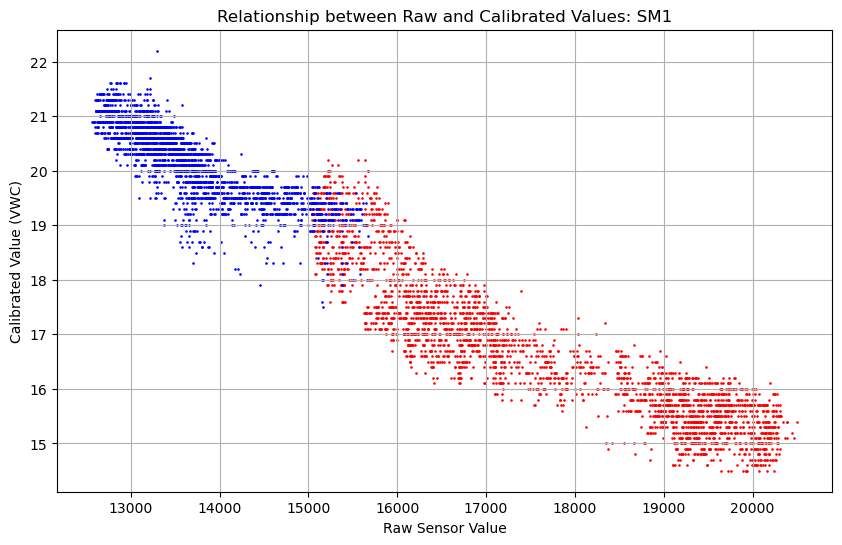

In [57]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import numpy as np

# Assuming your dataframes are named sm1_raw_df, sm1_vwc_df, and sm1_temp_df
# and the timestamp columns are named 'timestamp' (adjust if different)
# and the value columns are named 'SM_raw' and 'SM_vwc' (adjust if different)

# Merge the raw and calibrated value dataframes on the timestamp
merged_sm1_df = pd.merge(sm1_raw_df, sm1_vwc_df, on='Time', how='inner')
merged_sm2_df = pd.merge(sm2_raw_df, sm2_vwc_df, on='Time', how='inner')
merged_sm3_df = pd.merge(sm3_raw_df, sm3_vwc_df, on='Time', how='inner')

# Now 'merged_df' contains corresponding raw and calibrated values

# Step 1: Visualize the relationship (optional but highly recommended)
plt.figure(figsize=(10, 6))
plt.scatter(merged_sm1_df['SM_raw'], merged_sm1_df['SM_vwc'], s=3, marker='.', color='red', label='SM1')
plt.scatter(merged_sm2_df['SM_raw'], merged_sm2_df['SM_vwc'], s=3, marker='.', color='blue', label='SM2')
# plt.scatter(merged_sm3_df['SM_raw'], merged_sm3_df['SM_vwc'], s=3, marker='.', color='green', label='SM3')
plt.xlabel('Raw Sensor Value')
plt.ylabel('Calibrated Value (VWC)')
plt.title('Relationship between Raw and Calibrated Values: SM1')
plt.grid(True)
plt.show()

# Based on the visualization, you can decide on the type of calibration function.
# Common choices include:
# 1. Linear Regression: y = mx + c
# 2. Polynomial Regression: y = a_n * x^n + ... + a_1 * x + a_0
# 3. Other non-linear functions


In [58]:
import pandas as pd
import plotly.express as px

# Assuming your dataframes are named sm1_raw_df, sm1_vwc_df, and sm1_temp_df
# and the timestamp columns are named 'Time'
# and the value columns are named 'SM_raw', 'SM_vwc', and 'SM_temp'

# Merge the dataframes on 'Time'
merged_df = pd.merge(sm1_raw_df, sm1_vwc_df, on='Time', how='inner')
merged_df = pd.merge(merged_df, sm1_temp_df, on='Time', how='inner')

# Create the interactive 3D scatter plot using plotly
fig = px.scatter_3d(
    merged_df,
    x='SM_raw',
    y='SM_temp',
    z='SM_vwc',
    color='SM_vwc',  # Color points by the calibrated value
    labels={
        'SM_raw': 'Raw Sensor Value',
        'SM_temp': 'Temperature (°C)',
        'SM_vwc': 'Calibrated Value (VWC)'
    },
    title='Interactive 3D Visualization: Raw Value vs Calibrated Value vs Temperature'
)

# Show the interactive plot
fig.show()

In [59]:
import pandas as pd
import plotly.graph_objects as go

# Assuming your dataframes are named sm1_raw_df, sm1_vwc_df, and sm1_temp_df
# and the timestamp columns are named 'Time'
# and the value columns are named 'SM_raw', 'SM_vwc', and 'SM_temp'

# Merge the dataframes on 'Time'
merged_df = pd.merge(sm1_raw_df, sm1_vwc_df, on='Time', how='inner')
merged_df = pd.merge(merged_df, sm1_temp_df, on='Time', how='inner')

# Sort the dataframe by raw value and then by temperature
merged_df = merged_df.sort_values(by=['SM_raw', 'SM_temp'])

# Create the interactive 3D ribbon-like plot using plotly.graph_objects
fig = go.Figure(data=[go.Scatter3d(
    x=merged_df['SM_raw'],
    y=merged_df['SM_temp'],
    z=merged_df['SM_vwc'],
    mode='lines',
    line=dict(
        color=merged_df['SM_vwc'],
        colorscale='viridis',
        width=2
    ),
    marker=dict(  # Optional: Add markers at the points
        size=3,
        color=merged_df['SM_vwc'],
        colorscale='viridis',
        opacity=0.8
    ),
    text=[f"Raw: {r}<br>Temp: {t}<br>VWC: {v}" for r, t, v in zip(merged_df['SM_raw'], merged_df['SM_temp'], merged_df['SM_vwc'])],
    hoverinfo='text'
)])

# Update layout for better visualization
fig.update_layout(
    scene=dict(
        xaxis_title='Raw Sensor Value',
        yaxis_title='Temperature (°C or your unit)',
        zaxis_title='Calibrated Value (VWC)'
    ),
    title='Interactive 3D Ribbon-like Plot: Raw Value vs Temperature vs Calibrated Value'
)

# Show the interactive plot
fig.show()

In [60]:
import pandas as pd
import plotly.express as px

# Assuming your dataframes are named sm1_raw_df, sm1_vwc_df, and sm1_temp_df
# and the timestamp columns are named 'Time'
# and the value columns are named 'SM_raw', 'SM_vwc', and 'SM_temp'

# Merge the dataframes on 'Time'
merged_df = pd.merge(sm1_raw_df, sm1_vwc_df, on='Time', how='inner')
merged_df = pd.merge(merged_df, sm1_temp_df, on='Time', how='inner')

# Define VWC ranges
vwc_ranges = [
    (merged_df['SM_vwc'].min(), merged_df['SM_vwc'].quantile(0.33), 'Low VWC'),
    (merged_df['SM_vwc'].quantile(0.33), merged_df['SM_vwc'].quantile(0.66), 'Medium VWC'),
    (merged_df['SM_vwc'].quantile(0.66), merged_df['SM_vwc'].max(), 'High VWC')
]

# Create a new column to categorize VWC values into ranges
def categorize_vwc(vwc):
    for low, high, label in vwc_ranges:
        if low <= vwc <= high:
            return label
    return None

merged_df['VWC Category'] = merged_df['SM_vwc'].apply(categorize_vwc)

# Create an interactive scatter plot using plotly
fig = px.scatter(
    merged_df,
    x='SM_temp',
    y='SM_raw',
    color='VWC Category',
    labels={
        'SM_temp': 'Temperature (°C or your unit)',
        'SM_raw': 'Raw Sensor Value',
        'VWC Category': 'VWC Level'
    },
    title='Effect of Temperature on Raw Value for Different VWC Levels'
)

# Show the interactive plot
fig.show()

In [61]:
import pandas as pd
import plotly.express as px
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

# Assuming you have your merged_df with 'SM_raw', 'SM_vwc', 'SM_temp', and 'VWC Category'

# 1. Calculate Correlation (Example)
print("\nCorrelation between Temperature and Raw Value for each VWC Category:")
for category in merged_df['VWC Category'].unique():
    subset = merged_df[merged_df['VWC Category'] == category]
    correlation = subset['SM_temp'].corr(subset['SM_raw'])
    print(f"{category}: {correlation:.3f}")

# 2. Fit Regression Lines (Example using statsmodels)
print("\nRegression Analysis (Temperature vs. Raw Value) for each VWC Category:")
for category in merged_df['VWC Category'].unique():
    subset = merged_df[merged_df['VWC Category'] == category]
    model = smf.ols('SM_raw ~ SM_temp', data=subset).fit()
    print(f"\n{category} Regression Model:")
    print(model.summary())

    # To plot the regression line on your scatter plot (using plotly):
    fig = px.scatter(subset, x='SM_temp', y='SM_raw', title=f'Temperature vs Raw Value ({category})')
    fig.add_trace(go.Scatter(x=subset['SM_temp'].sort_values(), y=model.fittedvalues[subset['SM_temp'].sort_values().index], mode='lines', name='Regression Line'))
    fig.show()

# 3. Interaction Term in Regression (Example using statsmodels)
interaction_model = smf.ols('SM_raw ~ SM_temp * SM_vwc', data=merged_df).fit()
print("\nRegression Model with Interaction Term (Temperature * VWC):")
print(interaction_model.summary())

# 4. Box Plots (Example using plotly)
fig_box = px.box(merged_df, x='VWC Category', y='SM_raw', color='SM_temp',
                 title='Raw Value Distribution by VWC Category and Temperature (Box Plots)')
fig_box.show()

# You can adapt these examples to explore other methods mentioned above.


Correlation between Temperature and Raw Value for each VWC Category:
High VWC: 0.609
Medium VWC: 0.700
Low VWC: 0.405

Regression Analysis (Temperature vs. Raw Value) for each VWC Category:

High VWC Regression Model:
                            OLS Regression Results                            
Dep. Variable:                 SM_raw   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     553.2
Date:                Wed, 02 Apr 2025   Prob (F-statistic):           1.68e-96
Time:                        17:35:33   Log-Likelihood:                -7085.1
No. Observations:                 939   AIC:                         1.417e+04
Df Residuals:                     937   BIC:                         1.418e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                 


Medium VWC Regression Model:
                            OLS Regression Results                            
Dep. Variable:                 SM_raw   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     937.8
Date:                Wed, 02 Apr 2025   Prob (F-statistic):          7.80e-145
Time:                        17:35:33   Log-Likelihood:                -7860.8
No. Observations:                 977   AIC:                         1.573e+04
Df Residuals:                     975   BIC:                         1.574e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8956.2569 


Low VWC Regression Model:
                            OLS Regression Results                            
Dep. Variable:                 SM_raw   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     205.7
Date:                Wed, 02 Apr 2025   Prob (F-statistic):           9.95e-43
Time:                        17:35:33   Log-Likelihood:                -8041.3
No. Observations:                1052   AIC:                         1.609e+04
Df Residuals:                    1050   BIC:                         1.610e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    1.61e+04    


Regression Model with Interaction Term (Temperature * VWC):
                            OLS Regression Results                            
Dep. Variable:                 SM_raw   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     7774.
Date:                Wed, 02 Apr 2025   Prob (F-statistic):               0.00
Time:                        17:35:33   Log-Likelihood:                -22967.
No. Observations:                2968   AIC:                         4.594e+04
Df Residuals:                    2964   BIC:                         4.597e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

--- Random Split ---
Linear Regression (Raw Only):
  Mean Squared Error (MSE): 0.3473
  R-squared (R2): 0.8040

Polynomial Regression (Degree 2 - Raw Only):
  Mean Squared Error (MSE): 0.2803
  R-squared (R2): 0.8418

Multivariate Linear Regression (Raw + Temperature):
  Mean Squared Error (MSE): 0.3352
  R-squared (R2): 0.8108

Multivariate Polynomial Regression (Degree 2 - Raw + Temperature):
  Mean Squared Error (MSE): 0.2520
  R-squared (R2): 0.8578

Random Forest Regression (Raw Only):
  Mean Squared Error (MSE): 0.3724
  R-squared (R2): 0.7898

Random Forest Regression (Raw + Temperature):
  Mean Squared Error (MSE): 0.1726
  R-squared (R2): 0.9026

--- Time-Based Split ---
Linear Regression (Raw Only):
  Mean Squared Error (MSE): 0.2245
  R-squared (R2): -0.7062

Polynomial Regression (Degree 2 - Raw Only):
  Mean Squared Error (MSE): 0.3917
  R-squared (R2): -1.9771

Multivariate Linear Regression (Raw + Temperature):
  Mean Squared Error (MSE): 0.1941
  R-squared (R2): -0.4753

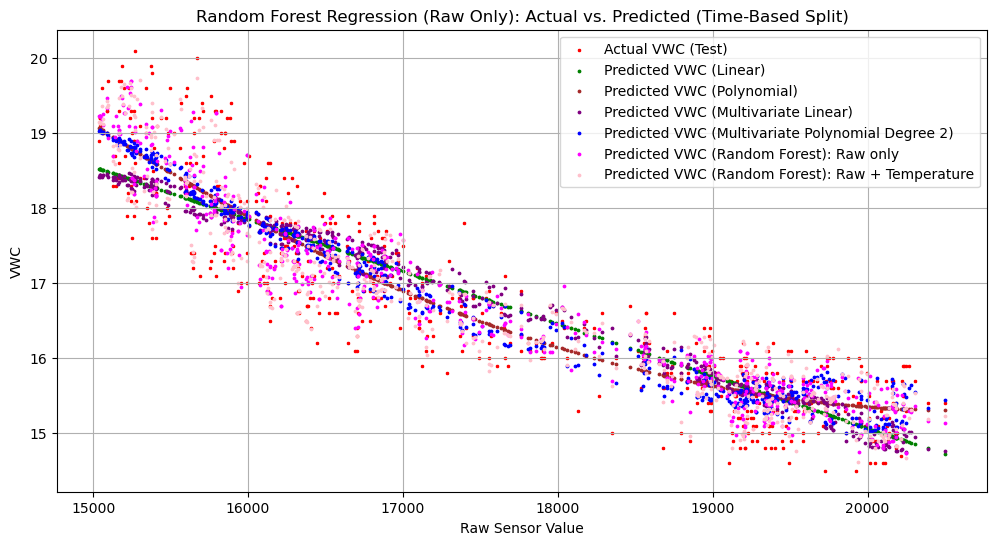


--- Comparing Model Performance ---
Random Split:
  Linear Regression (Raw Only) - MSE: 0.3473, R2: 0.8040
  Polynomial Regression (Degree 2 - Raw Only) - MSE: 0.2803, R2: 0.8418
  Multivariate Linear Regression (Raw + Temperature) - MSE: 0.3352, R2: 0.8108
  Multivariate Polynomial Regression (Degree 2 - Raw + Temperature) - MSE: 0.2520, R2: 0.8578
  Random Forest Regression (Raw Only) - MSE: 0.3724, R2: 0.7898
  Random Forest Regression (Raw + Temperature) - MSE: 0.1726, R2: 0.9026

Time-Based Split:
  Linear Regression (Raw Only) - MSE: 0.2245, R2: -0.7062
  Polynomial Regression (Degree 2 - Raw Only) - MSE: 0.3917, R2: -1.9771
  Multivariate Linear Regression (Raw + Temperature) - MSE: 0.1941, R2: -0.4753
  Multivariate Polynomial Regression (Degree 2 - Raw + Temperature) - MSE: 0.5208, R2: -2.9582
  Random Forest Regression (Raw Only) - MSE: 0.4093, R2: -2.1110
  Random Forest Regression (Raw + Temperature) - MSE: 0.3993, R2: -2.0352

Based on these comparison metrics, you can de

In [62]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np

# Assuming your dataframes are named sm1_raw_df, sm1_vwc_df, and sm1_temp_df
# and the timestamp columns are now named 'Time'
# and the value columns are named 'SM_raw' and 'SM_vwc'

# Merge the raw and calibrated value dataframes on 'Time'
merged_df = pd.merge(sm1_raw_df, sm1_vwc_df, on='Time', how='inner')

# Merge with the temperature dataframe on 'Time'
merged_df = pd.merge(merged_df, sm1_temp_df, on='Time', how='inner')

# ------------------------------------------------------------------------------
# 1. Random Split for Training and Validation
# ------------------------------------------------------------------------------

# Define the features (X) and the target (y)
X_random_raw = merged_df[['SM_raw']]
X_random_multi = merged_df[['SM_raw', 'SM_temp']]
y_random = merged_df['SM_vwc']

# Split the data into training and testing sets (e.g., 80% train, 20% test)
X_train_random_raw, X_test_random_raw, y_train_random, y_test_random = train_test_split(
    X_random_raw, y_random, test_size=0.2, random_state=42  # Set random_state for reproducibility
)

X_train_random_multi, X_test_random_multi, _, _ = train_test_split(
    X_random_multi, y_random, test_size=0.2, random_state=42  # Use the same split for consistency
)

print("--- Random Split ---")

# --- Linear Regression (Random Split - Raw Only) ---
linear_model_random = LinearRegression()
linear_model_random.fit(X_train_random_raw, y_train_random)
y_pred_linear_random = linear_model_random.predict(X_test_random_raw)

mse_linear_random = mean_squared_error(y_test_random, y_pred_linear_random)
r2_linear_random = r2_score(y_test_random, y_pred_linear_random)

print("Linear Regression (Raw Only):")
print(f"  Mean Squared Error (MSE): {mse_linear_random:.4f}")
print(f"  R-squared (R2): {r2_linear_random:.4f}")

# --- Polynomial Regression (Random Split - Raw Only) ---
poly_degree = 2  # Choose the degree
poly_features_random = PolynomialFeatures(degree=poly_degree)
X_train_poly_random = poly_features_random.fit_transform(X_train_random_raw)
X_test_poly_random = poly_features_random.transform(X_test_random_raw)

poly_model_random = LinearRegression()
poly_model_random.fit(X_train_poly_random, y_train_random)
y_pred_poly_random = poly_model_random.predict(X_test_poly_random)

mse_poly_random = mean_squared_error(y_test_random, y_pred_poly_random)
r2_poly_random = r2_score(y_test_random, y_pred_poly_random)

print(f"\nPolynomial Regression (Degree {poly_degree} - Raw Only):")
print(f"  Mean Squared Error (MSE): {mse_poly_random:.4f}")
print(f"  R-squared (R2): {r2_poly_random:.4f}")

# --- Multivariate Linear Regression (Random Split) ---
multi_linear_model_random = LinearRegression()
multi_linear_model_random.fit(X_train_random_multi, y_train_random)
y_pred_multi_linear_random = multi_linear_model_random.predict(X_test_random_multi)

mse_multi_linear_random = mean_squared_error(y_test_random, y_pred_multi_linear_random)
r2_multi_linear_random = r2_score(y_test_random, y_pred_multi_linear_random)

print(f"\nMultivariate Linear Regression (Raw + Temperature):")
print(f"  Mean Squared Error (MSE): {mse_multi_linear_random:.4f}")
print(f"  R-squared (R2): {r2_multi_linear_random:.4f}")

# --- Multivariate Polynomial Regression (Random Split) ---
multi_poly_degree = 2  # Choose the degree
multi_poly_features_random = PolynomialFeatures(degree=multi_poly_degree)
X_train_multi_poly_random = multi_poly_features_random.fit_transform(X_train_random_multi)
X_test_multi_poly_random = multi_poly_features_random.transform(X_test_random_multi)

multi_poly_model_random = LinearRegression()
multi_poly_model_random.fit(X_train_multi_poly_random, y_train_random)
y_pred_multi_poly_random = multi_poly_model_random.predict(X_test_multi_poly_random)

mse_multi_poly_random = mean_squared_error(y_test_random, y_pred_multi_poly_random)
r2_multi_poly_random = r2_score(y_test_random, y_pred_multi_poly_random)

print(f"\nMultivariate Polynomial Regression (Degree {multi_poly_degree} - Raw + Temperature):")
print(f"  Mean Squared Error (MSE): {mse_multi_poly_random:.4f}")
print(f"  R-squared (R2): {r2_multi_poly_random:.4f}")

# --- Random Forest Regression (Random Split - Raw Only) ---
rf_model_random_raw = RandomForestRegressor(random_state=42)
rf_model_random_raw.fit(X_train_random_raw, y_train_random)
y_pred_rf_random_raw = rf_model_random_raw.predict(X_test_random_raw)

mse_rf_random_raw = mean_squared_error(y_test_random, y_pred_rf_random_raw)
r2_rf_random_raw = r2_score(y_test_random, y_pred_rf_random_raw)

print(f"\nRandom Forest Regression (Raw Only):")
print(f"  Mean Squared Error (MSE): {mse_rf_random_raw:.4f}")
print(f"  R-squared (R2): {r2_rf_random_raw:.4f}")

# --- Random Forest Regression (Random Split - Raw + Temperature) ---
rf_model_random_multi = RandomForestRegressor(random_state=42)
rf_model_random_multi.fit(X_train_random_multi, y_train_random)
y_pred_rf_random_multi = rf_model_random_multi.predict(X_test_random_multi)

mse_rf_random_multi = mean_squared_error(y_test_random, y_pred_rf_random_multi)
r2_rf_random_multi = r2_score(y_test_random, y_pred_rf_random_multi)

print(f"\nRandom Forest Regression (Raw + Temperature):")
print(f"  Mean Squared Error (MSE): {mse_rf_random_multi:.4f}")
print(f"  R-squared (R2): {r2_rf_random_multi:.4f}")

# ------------------------------------------------------------------------------
# 2. Time-Based Split for Training and Validation
# ------------------------------------------------------------------------------

# Assuming your 'merged_df' has a 'Time' column in datetime format
merged_df['Time'] = pd.to_datetime(merged_df['Time'])
merged_df = merged_df.sort_values(by='Time')

# Determine a split point in time (e.g., use the first 80% of the data for training)
train_size = int(0.8 * len(merged_df))
train_df_time = merged_df[:train_size].copy()
test_df_time = merged_df[train_size:].copy()

X_train_time_raw = train_df_time[['SM_raw']]
y_train_time = train_df_time['SM_vwc']
X_test_time_raw = test_df_time[['SM_raw']]
y_test_time = test_df_time['SM_vwc']

X_train_time_multi = train_df_time[['SM_raw', 'SM_temp']]
X_test_time_multi = test_df_time[['SM_raw', 'SM_temp']]

print("\n--- Time-Based Split ---")

# --- Linear Regression (Time-Based Split - Raw Only) ---
linear_model_time = LinearRegression()
linear_model_time.fit(X_train_time_raw, y_train_time)
y_pred_linear_time = linear_model_time.predict(X_test_time_raw)

mse_linear_time = mean_squared_error(y_test_time, y_pred_linear_time)
r2_linear_time = r2_score(y_test_time, y_pred_linear_time)

print("Linear Regression (Raw Only):")
print(f"  Mean Squared Error (MSE): {mse_linear_time:.4f}")
print(f"  R-squared (R2): {r2_linear_time:.4f}")

# --- Polynomial Regression (Time-Based Split - Raw Only) ---
poly_degree = 2  # Choose the degree
poly_features_time = PolynomialFeatures(degree=poly_degree)
X_train_poly_time = poly_features_time.fit_transform(X_train_time_raw)
X_test_poly_time = poly_features_time.transform(X_test_time_raw)  # Transform the test data here

poly_model_time = LinearRegression()
poly_model_time.fit(X_train_poly_time, y_train_time)
y_pred_poly_time = poly_model_time.predict(X_test_poly_time)

mse_poly_time = mean_squared_error(y_test_time, y_pred_poly_time)
r2_poly_time = r2_score(y_test_time, y_pred_poly_time)

print(f"\nPolynomial Regression (Degree {poly_degree} - Raw Only):")
print(f"  Mean Squared Error (MSE): {mse_poly_time:.4f}")
print(f"  R-squared (R2): {r2_poly_time:.4f}")

# --- Multivariate Linear Regression (Time-Based Split) ---
multi_linear_model_time = LinearRegression()
multi_linear_model_time.fit(X_train_time_multi, y_train_time)
y_pred_multi_linear_time = multi_linear_model_time.predict(X_test_time_multi)

mse_multi_linear_time = mean_squared_error(y_test_time, y_pred_multi_linear_time)
r2_multi_linear_time = r2_score(y_test_time, y_pred_multi_linear_time)

print(f"\nMultivariate Linear Regression (Raw + Temperature):")
print(f"  Mean Squared Error (MSE): {mse_multi_linear_time:.4f}")
print(f"  R-squared (R2): {r2_multi_linear_time:.4f}")

# --- Multivariate Polynomial Regression (Time-Based Split) ---
multi_poly_degree = 2  # Choose the degree
multi_poly_features_time = PolynomialFeatures(degree=multi_poly_degree)
X_train_multi_poly_time = multi_poly_features_time.fit_transform(X_train_time_multi)
X_test_multi_poly_time = multi_poly_features_time.transform(X_test_time_multi)

multi_poly_model_time = LinearRegression()
multi_poly_model_time.fit(X_train_multi_poly_time, y_train_time)
y_pred_multi_poly_time = multi_poly_model_time.predict(X_test_multi_poly_time)

mse_multi_poly_time = mean_squared_error(y_test_time, y_pred_multi_poly_time)
r2_multi_poly_time = r2_score(y_test_time, y_pred_multi_poly_time)

print(f"\nMultivariate Polynomial Regression (Degree {multi_poly_degree} - Raw + Temperature):")
print(f"  Mean Squared Error (MSE): {mse_multi_poly_time:.4f}")
print(f"  R-squared (R2): {r2_multi_poly_time:.4f}")

# --- Random Forest Regression (Time-Based Split - Raw Only) ---
rf_model_time_raw = RandomForestRegressor(random_state=42)
rf_model_time_raw.fit(X_train_time_raw, y_train_time)
y_pred_rf_time_raw = rf_model_time_raw.predict(X_test_time_raw)

mse_rf_time_raw = mean_squared_error(y_test_time, y_pred_rf_time_raw)
r2_rf_time_raw = r2_score(y_test_time, y_pred_rf_time_raw)

print(f"\nRandom Forest Regression (Raw Only):")
print(f"  Mean Squared Error (MSE): {mse_rf_time_raw:.4f}")
print(f"  R-squared (R2): {r2_rf_time_raw:.4f}")

# --- Random Forest Regression (Time-Based Split - Raw + Temperature) ---
rf_model_time_multi = RandomForestRegressor(random_state=42)
rf_model_time_multi.fit(X_train_time_multi, y_train_time)
y_pred_rf_time_multi = rf_model_time_multi.predict(X_test_time_multi)

mse_rf_time_multi = mean_squared_error(y_test_time, y_pred_rf_time_multi)
r2_rf_time_multi = r2_score(y_test_time, y_pred_rf_time_multi)

print(f"\nRandom Forest Regression (Raw + Temperature):")
print(f"  Mean Squared Error (MSE): {mse_rf_time_multi:.4f}")
print(f"  R-squared (R2): {r2_rf_time_multi:.4f}")

# ------------------------------------------------------------------------------
# Visualization of Results (Optional but Recommended)
# ------------------------------------------------------------------------------

# Example for Time-Based Split (Random Forest Regression - Raw Only)
plt.figure(figsize=(12, 6))
plt.scatter(X_test_random_raw['SM_raw'], y_test_random, s=3, marker='x', color='red', label='Actual VWC (Test)')
plt.scatter(X_test_random_raw['SM_raw'], y_pred_linear_random, s=3, marker='o', color='green', label='Predicted VWC (Linear)')
plt.scatter(X_test_random_raw['SM_raw'], y_pred_poly_random, s=3, marker='o', color='brown', label='Predicted VWC (Polynomial)')
plt.scatter(X_test_random_raw['SM_raw'], y_pred_multi_linear_random, s=3, marker='o', color='purple', label='Predicted VWC (Multivariate Linear)')
plt.scatter(X_test_random_raw['SM_raw'], y_pred_multi_poly_random, s=3, marker='o', color='blue', label=f'Predicted VWC (Multivariate Polynomial Degree {multi_poly_degree})')
plt.scatter(X_test_random_raw['SM_raw'], y_pred_rf_random_raw, s=3, marker='o', color='magenta', label='Predicted VWC (Random Forest): Raw only')
plt.scatter(X_test_random_raw['SM_raw'], y_pred_rf_random_multi, s=3, marker='o', color='pink', label='Predicted VWC (Random Forest): Raw + Temperature')
plt.xlabel('Raw Sensor Value')
plt.ylabel('VWC')
plt.title('Random Forest Regression (Raw Only): Actual vs. Predicted (Time-Based Split)')
plt.legend()
plt.grid(True)
plt.show()

# You can create similar visualizations for other models and the random split.

# ------------------------------------------------------------------------------
# Choosing the Best Model - Comparison
# ------------------------------------------------------------------------------

print("\n--- Comparing Model Performance ---")
print("Random Split:")
print(f"  Linear Regression (Raw Only) - MSE: {mse_linear_random:.4f}, R2: {r2_linear_random:.4f}")
print(f"  Polynomial Regression (Degree {poly_degree} - Raw Only) - MSE: {mse_poly_random:.4f}, R2: {r2_poly_random:.4f}")
print(f"  Multivariate Linear Regression (Raw + Temperature) - MSE: {mse_multi_linear_random:.4f}, R2: {r2_multi_linear_random:.4f}")
print(f"  Multivariate Polynomial Regression (Degree {multi_poly_degree} - Raw + Temperature) - MSE: {mse_multi_poly_random:.4f}, R2: {r2_multi_poly_random:.4f}")
print(f"  Random Forest Regression (Raw Only) - MSE: {mse_rf_random_raw:.4f}, R2: {r2_rf_random_raw:.4f}")
print(f"  Random Forest Regression (Raw + Temperature) - MSE: {mse_rf_random_multi:.4f}, R2: {r2_rf_random_multi:.4f}")

print("\nTime-Based Split:")
print(f"  Linear Regression (Raw Only) - MSE: {mse_linear_time:.4f}, R2: {r2_linear_time:.4f}")
print(f"  Polynomial Regression (Degree {poly_degree} - Raw Only) - MSE: {mse_poly_time:.4f}, R2: {r2_poly_time:.4f}")
print(f"  Multivariate Linear Regression (Raw + Temperature) - MSE: {mse_multi_linear_time:.4f}, R2: {r2_multi_linear_time:.4f}")
print(f"  Multivariate Polynomial Regression (Degree {multi_poly_degree} - Raw + Temperature) - MSE: {mse_multi_poly_time:.4f}, R2: {r2_multi_poly_time:.4f}")
print(f"  Random Forest Regression (Raw Only) - MSE: {mse_rf_time_raw:.4f}, R2: {r2_rf_time_raw:.4f}")
print(f"  Random Forest Regression (Raw + Temperature) - MSE: {mse_rf_time_multi:.4f}, R2: {r2_rf_time_multi:.4f}")

print("\nBased on these comparison metrics, you can decide which calibration function works best for your data.")
print("Consider the MSE and R-squared values for all models under both the random and time-based splits.")
print("The time-based split is often more indicative of how the model will perform on future unseen data.")

In [63]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
from scipy.optimize import curve_fit

# Merge the raw and calibrated value dataframes on 'Time'
merged_df = pd.merge(sm1_raw_df, sm1_vwc_df, on='Time', how='inner')
# Merge with the temperature dataframe on 'Time'
merged_df = pd.merge(merged_df, sm1_temp_df, on='Time', how='inner')

# ------------------------------------------------------------------------------
# Define the power-law function
# ------------------------------------------------------------------------------
def power_law(x, a, b, c):
    return a * np.power(x, b) + c

# ------------------------------------------------------------------------------
# 1. Random Split for Training and Validation
# ------------------------------------------------------------------------------

# Define the features (X) and the target (y)
X_random_raw = merged_df[['SM_raw']]
X_random_multi = merged_df[['SM_raw', 'SM_temp']]
y_random = merged_df['SM_vwc']

# Split the data into training and testing sets (e.g., 80% train, 20% test)
X_train_random_raw, X_test_random_raw, y_train_random, y_test_random = train_test_split(
    X_random_raw, y_random, test_size=0.2, random_state=42  # Set random_state for reproducibility
)

X_train_random_multi, X_test_random_multi, _, _ = train_test_split(
    X_random_multi, y_random, test_size=0.2, random_state=42  # Use the same split for consistency
)

print("--- Random Split ---")

# --- Linear Regression (Random Split - Raw Only) ---
linear_model_random = LinearRegression()
linear_model_random.fit(X_train_random_raw, y_train_random)
y_pred_linear_random = linear_model_random.predict(X_test_random_raw)

mse_linear_random = mean_squared_error(y_test_random, y_pred_linear_random)
r2_linear_random = r2_score(y_test_random, y_pred_linear_random)

print("Linear Regression (Raw Only):")
print(f"  Mean Squared Error (MSE): {mse_linear_random:.4f}")
print(f"  R-squared (R2): {r2_linear_random:.4f}")

# --- Polynomial Regression (Random Split - Raw Only) ---
poly_degree = 2  # Choose the degree
poly_features_random = PolynomialFeatures(degree=poly_degree)
X_train_poly_random = poly_features_random.fit_transform(X_train_random_raw)
X_test_poly_random = poly_features_random.transform(X_test_random_raw)

poly_model_random = LinearRegression()
poly_model_random.fit(X_train_poly_random, y_train_random)
y_pred_poly_random = poly_model_random.predict(X_test_poly_random)

mse_poly_random = mean_squared_error(y_test_random, y_pred_poly_random)
r2_poly_random = r2_score(y_test_random, y_pred_poly_random)

print(f"\nPolynomial Regression (Degree {poly_degree} - Raw Only):")
print(f"  Mean Squared Error (MSE): {mse_poly_random:.4f}")
print(f"  R-squared (R2): {r2_poly_random:.4f}")

# --- Power-Law Regression (Random Split - Raw Only) ---
y_pred_power_random = None  # Initialize to handle cases where optimization fails
try:
    popt_power_random, pcov_power_random = curve_fit(power_law, X_train_random_raw['SM_raw'], y_train_random, p0=[3, -0.0001, 15], method='trf', maxfev=5000)
    # popt_power_random, pcov_power_random = curve_fit(power_law, X_train_random_raw['SM_raw'], y_train_random, p0=[3, -0.0001, 15], maxfev=50000)
    y_pred_power_random = power_law(X_test_random_raw['SM_raw'], *popt_power_random)
    mse_power_random = mean_squared_error(y_test_random, y_pred_power_random)
    r2_power_random = r2_score(y_test_random, y_pred_power_random)
    print(f"\nPower-Law Regression (Raw Only):")
    print(f"  Parameters (a, b, c): {popt_power_random}")
    print(f"  Mean Squared Error (MSE): {mse_power_random:.4f}")
    print(f"  R-squared (R2): {r2_power_random:.4f}")
except RuntimeError:
    print("\nPower-Law Regression (Raw Only): Optimization failed.")
    mse_power_random = np.nan
    r2_power_random = np.nan

# --- Multivariate Linear Regression (Random Split) ---
multi_linear_model_random = LinearRegression()
multi_linear_model_random.fit(X_train_random_multi, y_train_random)
y_pred_multi_linear_random = multi_linear_model_random.predict(X_test_random_multi)

mse_multi_linear_random = mean_squared_error(y_test_random, y_pred_multi_linear_random)
r2_multi_linear_random = r2_score(y_test_random, y_pred_multi_linear_random)

print(f"\nMultivariate Linear Regression (Raw + Temperature):")
print(f"  Mean Squared Error (MSE): {mse_multi_linear_random:.4f}")
print(f"  R-squared (R2): {r2_multi_linear_random:.4f}")

# --- Multivariate Polynomial Regression (Random Split) ---
multi_poly_degree = 2  # Choose the degree
multi_poly_features_random = PolynomialFeatures(degree=multi_poly_degree)
X_train_multi_poly_random = multi_poly_features_random.fit_transform(X_train_random_multi)
X_test_multi_poly_random = multi_poly_features_random.transform(X_test_random_multi)

multi_poly_model_random = LinearRegression()
multi_poly_model_random.fit(X_train_multi_poly_random, y_train_random)
y_pred_multi_poly_random = multi_poly_model_random.predict(X_test_multi_poly_random)

mse_multi_poly_random = mean_squared_error(y_test_random, y_pred_multi_poly_random)
r2_multi_poly_random = r2_score(y_test_random, y_pred_multi_poly_random)

print(f"\nMultivariate Polynomial Regression (Degree {multi_poly_degree} - Raw + Temperature):")
print(f"  Mean Squared Error (MSE): {mse_multi_poly_random:.4f}")
print(f"  R-squared (R2): {r2_multi_poly_random:.4f}")

# --- Random Forest Regression (Random Split - Raw Only) ---
rf_model_random_raw = RandomForestRegressor(random_state=42)
rf_model_random_raw.fit(X_train_random_raw, y_train_random)
y_pred_rf_random_raw = rf_model_random_raw.predict(X_test_random_raw)

mse_rf_random_raw = mean_squared_error(y_test_random, y_pred_rf_random_raw)
r2_rf_random_raw = r2_score(y_test_random, y_pred_rf_random_raw)

print(f"\nRandom Forest Regression (Raw Only):")
print(f"  Mean Squared Error (MSE): {mse_rf_random_raw:.4f}")
print(f"  R-squared (R2): {r2_rf_random_raw:.4f}")

# --- Random Forest Regression (Random Split - Raw + Temperature) ---
rf_model_random_multi = RandomForestRegressor(random_state=42)
rf_model_random_multi.fit(X_train_random_multi, y_train_random)
y_pred_rf_random_multi = rf_model_random_multi.predict(X_test_random_multi)

mse_rf_random_multi = mean_squared_error(y_test_random, y_pred_rf_random_multi)
r2_rf_random_multi = r2_score(y_test_random, y_pred_rf_random_multi)

print(f"\nRandom Forest Regression (Raw + Temperature):")
print(f"  Mean Squared Error (MSE): {mse_rf_random_multi:.4f}")
print(f"  R-squared (R2): {r2_rf_random_multi:.4f}")

# ------------------------------------------------------------------------------
# Visualization of Results (Optional but Recommended)
# ------------------------------------------------------------------------------

# Example for Random Split (Raw Only)
fig = go.Figure()

fig.add_trace(go.Scatter(x=X_test_random_raw['SM_raw'], y=y_test_random, mode='markers', name='Actual VWC (Test)', marker=dict(color='red')))
fig.add_trace(go.Scatter(x=X_test_random_raw['SM_raw'], y=y_pred_linear_random, mode='markers', name='Predicted VWC (Linear)', marker=dict(color='green')))
fig.add_trace(go.Scatter(x=X_test_random_raw['SM_raw'], y=y_pred_power_random, mode='markers', name='Predicted VWC (Power-Law)', marker=dict(color='orange')))
fig.add_trace(go.Scatter(x=X_test_random_raw['SM_raw'], y=y_pred_poly_random, mode='markers', name='Predicted VWC (Polynomial)', marker=dict(color='brown')))
fig.add_trace(go.Scatter(x=X_test_random_raw['SM_raw'], y=y_pred_multi_linear_random, mode='markers', name='Predicted VWC (Multivariate Linear)', marker=dict(color='purple')))
fig.add_trace(go.Scatter(x=X_test_random_raw['SM_raw'], y=y_pred_multi_poly_random, mode='markers', name=f'Predicted VWC (Multivariate Polynomial Degree {multi_poly_degree})', marker=dict(color='blue')))
fig.add_trace(go.Scatter(x=X_test_random_raw['SM_raw'], y=y_pred_rf_random_raw, mode='markers', name='Predicted VWC (Random Forest): Raw only', marker=dict(color='magenta')))
fig.add_trace(go.Scatter(x=X_test_random_raw['SM_raw'], y=y_pred_rf_random_multi, mode='markers', name='Predicted VWC (Random Forest): Raw + Temperature', marker=dict(color='pink')))

fig.update_layout(
    title='Comparison of Regression Models (Random Split - Raw Only)',
    xaxis_title='Raw Sensor Value',
    yaxis_title='VWC',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()

# ------------------------------------------------------------------------------
# Choosing the Best Model - Comparison
# ------------------------------------------------------------------------------

print("\n--- Comparing Model Performance ---")
print("Random Split:")
print(f"  Linear Regression (Raw Only) - MSE: {mse_linear_random:.4f}, R2: {r2_linear_random:.4f}")
print(f"  Polynomial Regression (Degree {poly_degree} - Raw Only) - MSE: {mse_poly_random:.4f}, R2: {r2_poly_random:.4f}")
print(f"  Power-Law Regression (Raw Only) - MSE: {mse_power_random:.4f}, R2: {r2_power_random:.4f}")
print(f"  Multivariate Linear Regression (Raw + Temperature) - MSE: {mse_multi_linear_random:.4f}, R2: {r2_multi_linear_random:.4f}")
print(f"  Multivariate Polynomial Regression (Degree {multi_poly_degree} - Raw + Temperature) - MSE: {mse_multi_poly_random:.4f}, R2: {r2_multi_poly_random:.4f}")
print(f"  Random Forest Regression (Raw Only) - MSE: {mse_rf_random_raw:.4f}, R2: {r2_rf_random_raw:.4f}")
print(f"  Random Forest Regression (Raw + Temperature) - MSE: {mse_rf_random_multi:.4f}, R2: {r2_rf_random_multi:.4f}")

print("\nBased on these comparison metrics, you can decide which calibration function works best for your data.")
print("Consider the MSE and R-squared values for all models under both the random and time-based splits.")
print("The time-based split is often more indicative of how the model will perform on future unseen data.")

--- Random Split ---
Linear Regression (Raw Only):
  Mean Squared Error (MSE): 0.3473
  R-squared (R2): 0.8040

Polynomial Regression (Degree 2 - Raw Only):
  Mean Squared Error (MSE): 0.2803
  R-squared (R2): 0.8418

Power-Law Regression (Raw Only):
  Parameters (a, b, c): [ 1.66994430e+22 -5.15093452e+00  1.41568740e+01]
  Mean Squared Error (MSE): 0.2793
  R-squared (R2): 0.8423

Multivariate Linear Regression (Raw + Temperature):
  Mean Squared Error (MSE): 0.3352
  R-squared (R2): 0.8108

Multivariate Polynomial Regression (Degree 2 - Raw + Temperature):
  Mean Squared Error (MSE): 0.2520
  R-squared (R2): 0.8578

Random Forest Regression (Raw Only):
  Mean Squared Error (MSE): 0.3724
  R-squared (R2): 0.7898

Random Forest Regression (Raw + Temperature):
  Mean Squared Error (MSE): 0.1726
  R-squared (R2): 0.9026



--- Comparing Model Performance ---
Random Split:
  Linear Regression (Raw Only) - MSE: 0.3473, R2: 0.8040
  Polynomial Regression (Degree 2 - Raw Only) - MSE: 0.2803, R2: 0.8418
  Power-Law Regression (Raw Only) - MSE: 0.2793, R2: 0.8423
  Multivariate Linear Regression (Raw + Temperature) - MSE: 0.3352, R2: 0.8108
  Multivariate Polynomial Regression (Degree 2 - Raw + Temperature) - MSE: 0.2520, R2: 0.8578
  Random Forest Regression (Raw Only) - MSE: 0.3724, R2: 0.7898
  Random Forest Regression (Raw + Temperature) - MSE: 0.1726, R2: 0.9026

Based on these comparison metrics, you can decide which calibration function works best for your data.
Consider the MSE and R-squared values for all models under both the random and time-based splits.
The time-based split is often more indicative of how the model will perform on future unseen data.


In [64]:
import copy

linmod = copy.deepcopy(linear_model_random)

sm_raw = pd.DataFrame({'SM_raw': np.linspace(1000, 30_000, 100)})
sm_vwc = linmod.predict(sm_raw)
px.line(x=sm_raw['SM_raw'], y=sm_vwc, title='Calibration Curve: Raw Value vs VWC')

In [65]:
sm2_merged_df = pd.merge(sm2_raw_df, sm2_temp_df, on='Time', how='inner')
sm2_merged_df = pd.merge(sm2_merged_df, sm2_vwc_df, on='Time', how='inner')
sm2_merged_df.dropna(subset=['SM_raw', 'SM_temp', 'SM_vwc'], inplace=True)

X_sm2_raw = sm2_merged_df[['SM_raw']]
y_pred_sm2_linear = linear_model_random.predict(X_sm2_raw)

# Linear Regression
mse_sm2_linear = mean_squared_error(sm2_merged_df['SM_vwc'], y_pred_sm2_linear)
rmse_sm2_linear = np.sqrt(mse_sm2_linear)
r2_sm2_linear = r2_score(sm2_merged_df['SM_vwc'], y_pred_sm2_linear)
print(f"\nLinear Regression (Raw Only):")
print(f"  MSE: {mse_sm2_linear:.4f}")
print(f"  RMSE: {rmse_sm2_linear:.4f}")
print(f"  R-squared (R2): {r2_sm2_linear:.4f}")

fig = go.Figure()
fig.add_trace(go.Scatter(x=sm2_merged_df['SM_raw'], y=sm2_merged_df['SM_vwc'],
                         mode='markers', name='Actual VWC (SM2)', marker=dict(color='red')))
fig.add_trace(go.Scatter(x=sm2_merged_df['SM_raw'], y=y_pred_sm2_linear,
                         mode='markers', name='Predicted VWC (Linear)', marker=dict(color='green')))


Linear Regression (Raw Only):
  MSE: 0.6028
  RMSE: 0.7764
  R-squared (R2): -0.3275


In [66]:
import pandas as pd
import plotly.graph_objects as go

sm2_merged_df = pd.merge(sm2_raw_df, sm2_temp_df, on='Time', how='inner')
sm2_merged_df = pd.merge(sm2_merged_df, sm2_vwc_df, on='Time', how='inner')
sm2_merged_df.dropna(subset=['SM_raw', 'SM_temp', 'SM_vwc'], inplace=True)

# Prepare features for sm2 data
X_sm2_raw = sm2_merged_df[['SM_raw']]
X_sm2_multi = sm2_merged_df[['SM_raw', 'SM_temp']]
X_sm2_poly = poly_features_random.transform(X_sm2_raw)
X_sm2_multi_poly = multi_poly_features_random.transform(X_sm2_multi.values)

# Make predictions for sm2 data
y_pred_sm2_linear = linear_model_random.predict(X_sm2_raw)
y_pred_sm2_multi_linear = multi_linear_model_random.predict(X_sm2_multi)
y_pred_sm2_power = power_law(X_sm2_raw['SM_raw'], *popt_power_random)
y_pred_sm2_poly = poly_model_random.predict(X_sm2_poly)
y_pred_sm2_multi_poly = multi_poly_model_random.predict(X_sm2_multi_poly)
y_pred_sm2_rf_raw = rf_model_random_raw.predict(X_sm2_raw)
y_pred_sm2_rf_temp = rf_model_random_multi.predict(X_sm2_multi)

# Calculate and print results for sm2 predictions

print("\n--- Validation Results for SM2 ---")

# Linear Regression
mse_sm2_linear = mean_squared_error(sm2_merged_df['SM_vwc'], y_pred_sm2_linear)
rmse_sm2_linear = np.sqrt(mse_sm2_linear)
r2_sm2_linear = r2_score(sm2_merged_df['SM_vwc'], y_pred_sm2_linear)
print(f"\nLinear Regression (Raw Only):")
print(f"  MSE: {mse_sm2_linear:.4f}")
print(f"  RMSE: {rmse_sm2_linear:.4f}")
print(f"  R-squared (R2): {r2_sm2_linear:.4f}")

# Multivariate Linear
mse_sm2_multi_linear = mean_squared_error(sm2_merged_df['SM_vwc'], y_pred_sm2_multi_linear)
rmse_sm2_multi_linear = np.sqrt(mse_sm2_multi_linear)
r2_sm2_multi_linear = r2_score(sm2_merged_df['SM_vwc'], y_pred_sm2_multi_linear)
print(f"\nMultivariate Linear Regression (Raw + Temperature):")
print(f"  MSE: {mse_sm2_multi_linear:.4f}")
print(f"  RMSE: {rmse_sm2_multi_linear:.4f}")
print(f"  R-squared (R2): {r2_sm2_multi_linear:.4f}")


# Power-Law Regression
if y_pred_sm2_power is not None:
    mse_sm2_power = mean_squared_error(sm2_merged_df['SM_vwc'], y_pred_sm2_power)
    rmse_sm2_power = np.sqrt(mse_sm2_power)
    r2_sm2_power = r2_score(sm2_merged_df['SM_vwc'], y_pred_sm2_power)
    print(f"\nPower-Law Regression (Raw Only):")
    print(f"  MSE: {mse_sm2_power:.4f}")
    print(f"  RMSE: {rmse_sm2_power:.4f}")
    print(f"  R-squared (R2): {r2_sm2_power:.4f}")
else:
    print("\nPower-Law Regression (Raw Only): Not evaluated as training failed.")

# Polynomial Regression
mse_sm2_poly = mean_squared_error(sm2_merged_df['SM_vwc'], y_pred_sm2_poly)
rmse_sm2_poly = np.sqrt(mse_sm2_poly)
r2_sm2_poly = r2_score(sm2_merged_df['SM_vwc'], y_pred_sm2_poly)
print(f"\nPolynomial Regression (Degree 2 - Raw Only):")
print(f"  MSE: {mse_sm2_poly:.4f}")
print(f"  RMSE: {rmse_sm2_poly:.4f}")
print(f"  R-squared (R2): {r2_sm2_poly:.4f}")

# Multivariate Polynomial Regression
mse_sm2_multi_poly = mean_squared_error(sm2_merged_df['SM_vwc'], y_pred_sm2_multi_poly)
rmse_sm2_multi_poly = np.sqrt(mse_sm2_multi_poly)
r2_sm2_multi_poly = r2_score(sm2_merged_df['SM_vwc'], y_pred_sm2_multi_poly)
print(f"\nMultivariate Polynomial Regression (Degree {multi_poly_degree} - Raw + Temperature):")
print(f"  MSE: {mse_sm2_multi_poly:.4f}")
print(f"  RMSE: {rmse_sm2_multi_poly:.4f}")
print(f"  R-squared (R2): {r2_sm2_multi_poly:.4f}")

# Random Forest Regression (Raw Only)
mse_sm2_rf_raw = mean_squared_error(sm2_merged_df['SM_vwc'], y_pred_sm2_rf_raw)
rmse_sm2_rf_raw = np.sqrt(mse_sm2_rf_raw)
r2_sm2_rf_raw = r2_score(sm2_merged_df['SM_vwc'], y_pred_sm2_rf_raw)
print(f"\nRandom Forest Regression (Raw Only):")
print(f"  MSE: {mse_sm2_rf_raw:.4f}")
print(f"  RMSE: {rmse_sm2_rf_raw:.4f}")
print(f"  R-squared (R2): {r2_sm2_rf_raw:.4f}")

# Random Forest Regression (Raw + Temperature)
mse_sm2_rf_temp = mean_squared_error(sm2_merged_df['SM_vwc'], y_pred_sm2_rf_temp)
rmse_sm2_rf_temp = np.sqrt(mse_sm2_rf_temp)
r2_sm2_rf_temp = r2_score(sm2_merged_df['SM_vwc'], y_pred_sm2_rf_temp)
print(f"\nRandom Forest Regression (Raw + Temperature):")
print(f"  MSE: {mse_sm2_rf_temp:.4f}")
print(f"  RMSE: {rmse_sm2_rf_temp:.4f}")
print(f"  R-squared (R2): {r2_sm2_rf_temp:.4f}")

# Create Plotly scatter plot
fig = go.Figure()

# Actual VWC for sm2
fig.add_trace(go.Scatter(x=sm2_merged_df['SM_raw'], y=sm2_merged_df['SM_vwc'],
                         mode='markers', name='Actual VWC (SM2)', marker=dict(color='red')))

# Predictions from different models
fig.add_trace(go.Scatter(x=sm2_merged_df['SM_raw'], y=y_pred_sm2_linear,
                         mode='markers', name='Predicted VWC (Linear)', marker=dict(color='green')))

fig.add_trace(go.Scatter(x=sm2_merged_df['SM_raw'], y=y_pred_sm2_power,
                             mode='markers', name='Predicted VWC (Power-Law)', marker=dict(color='orange')))

fig.add_trace(go.Scatter(x=sm2_merged_df['SM_raw'], y=y_pred_sm2_poly,
                         mode='markers', name='Predicted VWC (Polynomial)', marker=dict(color='brown')))

fig.add_trace(go.Scatter(x=sm2_merged_df['SM_raw'], y=y_pred_sm2_multi_linear,
                         mode='markers', name='Predicted VWC (Multivariate Linear)', marker=dict(color='purple')))

fig.add_trace(go.Scatter(x=sm2_merged_df['SM_raw'], y=y_pred_sm2_multi_poly,
                         mode='markers', name=f'Predicted VWC (Multivariate Polynomial Degree {multi_poly_degree})', marker=dict(color='blue')))

fig.add_trace(go.Scatter(x=sm2_merged_df['SM_raw'], y=y_pred_sm2_rf_raw,
                         mode='markers', name='Predicted VWC (Random Forest): Raw only', marker=dict(color='magenta')))

fig.add_trace(go.Scatter(x=sm2_merged_df['SM_raw'], y=y_pred_sm2_rf_temp,
                         mode='markers', name='Predicted VWC (Random Forest): Raw + Temperature', marker=dict(color='pink')))

fig.update_layout(
    title='Actual vs. Predicted VWC for SM2',
    xaxis_title='Raw Sensor Value (SM2)',
    yaxis_title='VWC',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()


--- Validation Results for SM2 ---

Linear Regression (Raw Only):
  MSE: 0.6028
  RMSE: 0.7764
  R-squared (R2): -0.3275

Multivariate Linear Regression (Raw + Temperature):
  MSE: 0.3098
  RMSE: 0.5566
  R-squared (R2): 0.3177

Power-Law Regression (Raw Only):
  MSE: 9.5895
  RMSE: 3.0967
  R-squared (R2): -20.1191

Polynomial Regression (Degree 2 - Raw Only):
  MSE: 1.5340
  RMSE: 1.2385
  R-squared (R2): -2.3783

Multivariate Polynomial Regression (Degree 2 - Raw + Temperature):
  MSE: 2.6961
  RMSE: 1.6420
  R-squared (R2): -4.9376

Random Forest Regression (Raw Only):
  MSE: 1.3316
  RMSE: 1.1539
  R-squared (R2): -1.9325

Random Forest Regression (Raw + Temperature):
  MSE: 1.1563
  RMSE: 1.0753
  R-squared (R2): -1.5464


c:\Users\veeth\miniconda3\envs\data_analysis\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but PolynomialFeatures was fitted with feature names



In [67]:
fig = px.line(station, x='Time', y='batt_p', title=f'Station {stn.upper()}: Battery Percentage')
fig.update_traces(line=dict(color='cyan'))
# fig.write_html(f'./vis/station_{stn}_batt.html')
fig.show()

In [68]:
fig = px.line(station, x='Time', y='itemp', title=f'Station {stn.upper()}: Internal Temperature')
fig.update_traces(line=dict(color='orange'))
# fig.write_html(f'./vis/station_{stn}_itemp.html')
fig.show()